This notebook shows how to use `standax` to fit for standardisation parameters, using the publically available ZTF DR2 data. It also includes more advanced examples (e.g. how to add priors on parameters). To have the packages version of the standardisation fitting method, see the notebook `Standardisation_Ginolin24b.ipynb` at https://github.com/mginolin/standax/tree/main/notebooks.

In [1]:
import ztfcosmo
import numpy as np
from astropy.cosmology import Planck18
from scipy import stats
import matplotlib.pyplot as plt
from standax import standardisation
import jax.numpy as jnp
from jax import tree_util
import pandas

# Access ZTF SN Ia DR2 data

In [2]:
# Masterlist for SNe used in Ginolin+24a,b (available at https://github.com/mginolin/standax/)
g24ab_masterlist = pandas.read_csv('Ginolin24ab_masterlist.csv')
data = ztfcosmo.get_data(good_coverage=True, good_lcfit=True)
data = data[(data.index.isin(g24ab_masterlist['ztfname'])) & (data['redshift'] > 0.015)]

In [3]:
# x0 to non-standardized Hubble residual (i.e. no cosmological fit)

data["mag"] = (-2.5*np.log10(data["x0"])+10.50) + 19.3 - Planck18.distmod(data["redshift"].values).value
data["mag_err"] = +2.5/np.log(10) * data["x0_err"] / data["x0"]
data["cov_mag_c"] = -2.5*np.array(data['cov_x0_c'])/(np.log(10)*data['x0'])
data["cov_mag_x1"] = -2.5*np.array(data['cov_x0_x1'])/(np.log(10)*data['x0'])

In [4]:
# Define the host environment tracer

data["h_low"] = stats.norm.cdf(1, loc=data["localrestframe_gz"], scale=data["localrestframe_gz_err"])
data["h_low_err"] = 1e-4

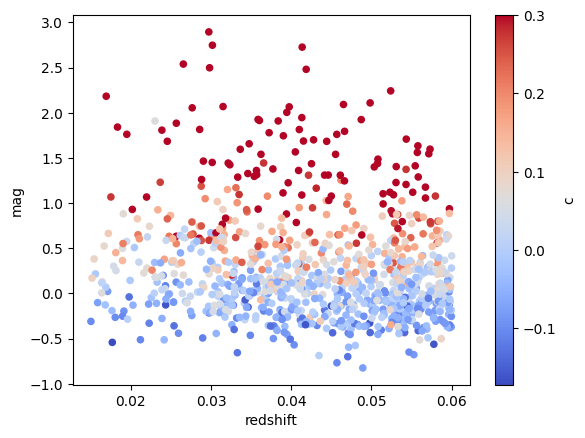

In [5]:
data.plot.scatter("redshift", "mag", c="c", vmax=0.3, cmap="coolwarm")
plt.show()

# Simple standardisation

In [15]:
data_to_fit = data[["mag", "mag_err", "x1", "x1_err", "c", "c_err", "h_low", "h_low_err",
                    "cov_mag_c", "cov_mag_x1", "cov_x1_c"]].dropna()

(best_params_l, sigmaint_l, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit,
                                                      init=[-0.2, 3.2, 0.1], 
                                                      xkeys=["x1", "c", "h_low"], 
                                                      sigmaint_guess=0.15, 
                                                      model="linear", 
                                                      nfetch=10, verbose=False,
                                                     lmbda=1e4, fit_method="tncg")

In [7]:
alpha = best_params_l['coefs'][0]
chain_alpha = mcmc_l.get_samples()['coefs'][:,0]
alpha_err = np.sqrt(np.sum((chain_alpha-alpha)**2)/len(chain_alpha))
beta = best_params_l['coefs'][1]
chain_beta = mcmc_l.get_samples()['coefs'][:,1]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
step = best_params_l['coefs'][2]
chain_step = mcmc_l.get_samples()['coefs'][:,2]
step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = best_params_l['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))

In [8]:
print(alpha, alpha_err)
print(beta, beta_err)
print(step, step_err)

-0.16436653 0.009300807
3.126666 0.048758898
0.15437388 0.021175086


# Broken-$\alpha$ standardisation

To fit for a broken-linear relation for one of the parameters of the standardisation, change the model from `linear` to `broken_linear`. This will apply to the first of the parameters in `xkeys`.

In [9]:
init = {"coefs": jnp.asarray([-0.2, -0.05, 3.3, 0.13], dtype="float32"),
        "xbreak": jnp.asarray(-0.5, dtype="float32")}

niter_sig = 10 # Number of iterations for the intrinsic scatter fit
(fid, sigmaint, mcmc_l), this_l = standardisation.standardise_snia(data_to_fit, init=init, 
                            xkeys=["x1", "c", "h_low"], sigmaint_guess=0.15, model="brokenlinear", nfetch=niter_sig, 
                                                            verbose=False, lmbda=1e4, fit_method="tncg")
alpha_low = fid['coefs'][0]
chain_alpha_low = mcmc_l.get_samples()['coefs'][:,0]
alpha_low_err = np.sqrt(np.sum((chain_alpha_low-alpha_low)**2)/len(chain_alpha_low))
alpha_high = fid['coefs'][1]
chain_alpha_high = mcmc_l.get_samples()['coefs'][:,1]
alpha_high_err = np.sqrt(np.sum((chain_alpha_high-alpha_high)**2)/len(chain_alpha_high))
beta = fid['coefs'][2]
chain_beta = mcmc_l.get_samples()['coefs'][:,2]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
step = fid['coefs'][3]
chain_step = mcmc_l.get_samples()['coefs'][:,3]
step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = fid['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))
xbreak = fid['xbreak']
chain_xbreak = mcmc_l.get_samples()['xbreak']
xbreak_err = np.sqrt(np.sum((chain_xbreak-xbreak)**2)/len(chain_xbreak))

In [10]:
print(alpha_low, alpha_low_err)
print(alpha_high, alpha_high_err)
print(xbreak, xbreak_err)
print(beta, beta_err)
print(step, step_err)

-0.2631146 0.011250246
-0.07537078 0.011222181
-0.38904995 0.07413884
3.284765 0.030905128
0.17180948 0.011292392


# Advanced examples

This are just example on how to add priors to any of the parameters. This may be implemented as part of the package in the future.

In [11]:
class LinearModelPrior( standardisation.LinearModel ):
    
    def get_likelihood(self, params, sigmaint=0, **kwargs):
        """ """
        chi2, logdet = self.get_chi2_logdet(params, 
                                            data=self.data, 
                                            sigmaint=sigmaint, 
                                            **kwargs)
        logprior = self.prior(params)
        return chi2 + logdet + logprior
    
    @property
    def prior(self):
        if not hasattr(self, "_prior"):
            def f(coefs):
                return 1.
            self._prior = f
        return self._prior

    def set_prior(self, prior):
        self._prior = prior


class BrokenLinearModelPrior( standardisation.BrokenLinearModel ):
    
    def get_likelihood(self, params, sigmaint=0, **kwargs):
        """ """
        chi2, logdet = self.get_chi2_logdet(params, 
                                            data=self.data, 
                                            sigmaint=sigmaint, 
                                            **kwargs)
        logprior = self.prior(params)
        return chi2 + logdet + logprior
    
    @property
    def prior(self):
        if not hasattr(self, "_prior"):
            def f(coefs):
                return 1.
            self._prior = f
        return self._prior

    def set_prior(self, prior):
        self._prior = prior

This is example when adding a Gaussian prior on the step, centered on 0.

In [12]:
niter_sig = 10
this = standardisation.Standardize.from_data(data_to_fit, xkeys=["x1", "c", "h_low"], ykey="mag", 
                                                   model=LinearModelPrior,
                                                  lmda=1e4, fit_method="tncg")
def logprior(params):
    return (params['coefs'][2])**2/(0.02)**2
this.model.set_prior(logprior)
(fid, sigmaint, loss), mcmc_l = this.fit(init=[-0.15, 3.2, 0.1], sigmaint=0.15, nfetch=niter_sig, 
                                         num_samples=1000, verbose=False)
alpha = fid['coefs'][0]
chain_alpha = mcmc_l.get_samples()['coefs'][:,0]
alpha_err = np.sqrt(np.sum((chain_alpha-alpha)**2)/len(chain_alpha))
beta = fid['coefs'][1]
chain_beta = mcmc_l.get_samples()['coefs'][:,1]
beta_err = np.sqrt(np.sum((chain_beta-beta)**2)/len(chain_beta))
step = fid['coefs'][2]
chain_step = mcmc_l.get_samples()['coefs'][:,2]
step_err = np.sqrt(np.sum((chain_step-step)**2)/len(chain_step))
offset = fid['offset']
chain_offset = mcmc_l.get_samples()['offset']
offset_err = np.sqrt(np.sum((chain_offset-offset)**2)/len(chain_offset))

In [13]:
print(alpha, alpha_err)
print(beta, beta_err)
print(step, step_err)

-0.14992802 0.009247578
3.100454 0.05534151
0.08764551 0.018166885
